# Rojové algoritmy

Na dnešním cvičení se podíváme na další druhy přírodou inspirovaných algoritmů, které se používají pro optimalizační úlohy. Konkrétně to bude algoritmus na optimalizaci pomocí hejna částic a optimalizaci mravenčí kolonií. Oba algoritmy jsou relativně jednoduché na implementaci, a proto je napíšeme sami.

## Optimalizace hejnem částic

Nejprve se zkusíme podívat na algoritmus optimalizace hejnem částic (v angličtině particle swarm optomalization (PSO)). Implementace je snadná, protože de facto stačí jenom opsat rovnice.

In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Zároveň si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [2]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ', ' + str(self.speed) + ', ' + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. Dále budeme potřebovat funkcei na update všech pozic a rychlostí částic v hejnu. Také bude potřeba funkce na update nejlepšího globálního řešení. Ještě si definujeme fitness funkci, která bude jen hodnota rastrigin funkce v daném bodě. Potom už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [7]:
# nahodna inicializace hejna
def init_swarm(size, dimension):
    swarm = []
    for _ in range(size):
        swarm.append(Particle(position = np.random.uniform(size=(1,dimension)), 
                              speed = 0.2*np.random.uniform(size=(1,dimension)) - 0.1))
    return swarm

# aktualizace hejna
def update_swarm(swarm, fit, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = omega*particle.speed + phi1*(particle.best_position - particle.position) + phi2*(best_global - particle.position)
        particle.position = particle.position + particle.speed
        
        if fit(particle.position) < fit(particle.best_position):
            particle.best_position=particle.position

    return swarm

# nalezeni nejlepsiho globalniho reseni
def compute_best_global_position(swarm, fit):
    return min(swarm, key=lambda x: fit(x.best_position)).best_position

# fitness funkce
def fitness(position):
    position = position[0]
    N = len(position)
    A = 10
    value = A*N
    for i in range(0,len(position)):
        value += position[i]**2 - A*math.cos(2*math.pi*position[i])
    return value, 


# algoritmus optimalizace hejnem castic
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness)
    best_fitness = []
    for iteration in range(max_iters):
        swarm = update_swarm(swarm, fitness, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness)
        print(f'{iteration:4}: {fitness(best_global_position)[0]:.4f}')
        best_fitness.append(fitness(best_global_position)[0])
    return best_global_position, best_fitness

Když máme napsaný celý algoritmus, můžeme ho zkusit otestovat například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy. O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v bodě 0 s hodnoutou 0.

   0: 5.1132
   1: 1.3996
   2: 1.0346
   3: 1.0346
   4: 1.0346
   5: 1.0346
   6: 1.0346
   7: 1.0346
   8: 1.0266
   9: 1.0047
  10: 1.0047
  11: 1.0047
  12: 1.0047
  13: 1.0047
  14: 1.0047
  15: 1.0006
  16: 0.9962
  17: 0.9962
  18: 0.9962
  19: 0.9962
  20: 0.9962
  21: 0.9961
  22: 0.9961
  23: 0.9955
  24: 0.9953
  25: 0.9953
  26: 0.9953
  27: 0.9953
  28: 0.9953
  29: 0.9952
best position
[[ 1.19394876e-04 -1.47559059e-05  9.95039940e-01 -1.13525126e-03]]


Text(0.5,0,'Generace')

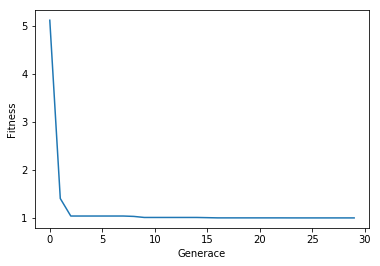

In [8]:
best_position, best_fitness = pso(fitness, swarm_size=1000, problem_dim=4, max_iters=30)
print('best position')
print(best_position)

plt.plot(best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.

## Optimalizace mravenčí kolonií

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na hledání cest v grafu. Zkusíme si s jeho pomocí vyřešit problém obchodního cestujícího, který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Implementace už je trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci ```namedtuple```, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu lru (least recently used) cache, která si pamatuje si vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu nevyhodnocovat. Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, ze bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, která by sice měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo, tak ji nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně tu fitness, která říká, jak byla váha dobrá. A protože délku chceme minimalizovat, takže použijeme inverzní Q/fit, kde Q bude nějaká konstanta.

Ještě nám zbývá pomocná funkce, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [9]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

def fitness(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    return solution_distance

def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

# vytvoreni reseni
def generate_solutions(vertices, pheromones, distance, N, alpha=1, beta=3):
    
    # pravdepodobnost vyberu dalsiho mesta
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(pheromones_shape))
        solution = [np.random.randint(0, pheromones_shape)]
        available.remove(solution[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            solution.append(selected)
            available.remove(selected)
        yield solution

# hlavni kod ACO
def ant_solver(vertices, distance, ants=10, max_iterations=3000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

Zkusíme si nyní algoritmus otestovat na hlavních evropských městech, vstupní data jsou uložena v souboru *cities.csv*.

In [10]:
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

best_solution, pheromones = ant_solver(vertices, distance)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

 170, 255.3323, 287.6879, 329.6801
 171, 244.4938, 276.2889, 306.9810
 172, 250.6548, 288.3030, 335.7735
 173, 242.4111, 280.2581, 323.2228
 174, 259.1949, 293.5366, 316.7790
 175, 246.6675, 283.9312, 319.2153
 176, 252.8102, 286.2332, 319.1003
 177, 262.3210, 285.2485, 313.4454
 178, 254.1810, 286.1247, 324.5864
 179, 271.3734, 297.7663, 334.8856
 180, 254.9330, 280.7894, 300.4260
 181, 252.0342, 285.8710, 318.8431
 182, 243.1495, 290.8245, 327.3500
 183, 244.4554, 294.0526, 350.0746
 184, 241.0861, 293.4826, 355.6960
 185, 271.4054, 300.5282, 340.5788
 186, 271.1616, 296.6159, 322.9070
 187, 252.9318, 291.2088, 328.4272
 188, 265.7835, 292.8300, 328.3996
 189, 252.9318, 292.1988, 341.9726
 190, 279.8021, 301.3577, 322.1691
 191, 275.7334, 303.8524, 337.3827
 192, 285.8586, 301.9340, 324.8347
 193, 284.9783, 306.6022, 339.5139
 194, 276.5051, 300.0753, 325.8000
 195, 284.4159, 301.1195, 318.4040
 196, 273.8150, 296.5542, 311.8026
 197, 279.4132, 292.1145, 304.0577
 198, 279.9799, 290.

 405, 248.8256, 280.4424, 304.1623
 406, 243.7315, 274.4491, 310.2780
 407, 251.4834, 269.3502, 306.1061
 408, 260.7656, 280.3642, 305.6144
 409, 248.3923, 275.9014, 306.6637
 410, 258.3806, 278.2681, 303.1723
 411, 244.3118, 267.5448, 288.1183
 412, 251.0955, 277.0343, 303.7108
 413, 257.3252, 288.5197, 314.1151
 414, 260.4906, 282.2095, 316.5181
 415, 250.4242, 280.4416, 375.6425
 416, 252.6371, 277.6203, 310.4359
 417, 246.6807, 283.7719, 336.0690
 418, 253.3777, 271.8435, 313.8777
 419, 243.1162, 264.0577, 289.8861
 420, 245.1333, 270.3884, 306.0641
 421, 251.1634, 274.0349, 304.8649
 422, 259.3740, 285.7651, 320.8365
 423, 247.1979, 280.9733, 332.1695
 424, 240.6681, 285.0730, 331.5411
 425, 240.6681, 267.8103, 291.1922
 426, 245.8597, 275.3914, 344.2965
 427, 240.6681, 267.3044, 288.9484
 428, 247.9723, 277.7677, 326.6599
 429, 232.4737, 270.7255, 345.8878
 430, 251.1018, 264.3017, 278.0305
 431, 240.8000, 261.7641, 322.1194
 432, 241.6518, 263.7914, 314.6399
 433, 244.1876, 260.

 643, 254.5096, 292.2515, 314.9261
 644, 254.9114, 286.7484, 325.7572
 645, 275.3793, 297.3004, 344.0326
 646, 266.9176, 295.3493, 316.1710
 647, 259.8714, 283.7802, 301.4923
 648, 258.8423, 298.1370, 346.6697
 649, 269.8545, 308.6000, 338.9548
 650, 271.4320, 304.5898, 340.3653
 651, 262.4778, 298.9878, 331.4174
 652, 248.3877, 298.1912, 326.4177
 653, 252.8244, 300.4879, 345.3033
 654, 247.1349, 293.0861, 360.5453
 655, 259.0984, 286.9912, 319.6752
 656, 251.3194, 282.6317, 323.2954
 657, 248.0810, 284.8395, 315.2415
 658, 248.0810, 294.3720, 370.0553
 659, 241.6793, 280.7210, 326.9769
 660, 242.1386, 280.2405, 343.6014
 661, 263.7079, 286.5678, 314.4811
 662, 260.3489, 284.3538, 302.7230
 663, 257.1005, 288.2513, 318.2376
 664, 252.1085, 277.1446, 297.7355
 665, 256.0124, 281.8763, 314.8743
 666, 263.2342, 277.0370, 306.3516
 667, 269.8868, 283.7613, 304.3508
 668, 242.1386, 281.7927, 317.4799
 669, 269.6544, 286.7637, 317.2061
 670, 242.2953, 290.2416, 316.2062
 671, 242.2953, 286.

 878, 264.0095, 293.6015, 361.6182
 879, 258.5367, 291.2273, 320.2110
 880, 256.5094, 293.7324, 335.3842
 881, 258.3288, 286.5743, 316.9551
 882, 244.1463, 275.5168, 293.5761
 883, 246.8873, 273.1030, 301.7328
 884, 264.9262, 280.6185, 297.0205
 885, 243.6895, 266.5066, 297.3286
 886, 244.0755, 279.5587, 350.2075
 887, 236.3869, 271.1082, 297.8749
 888, 251.9221, 269.1775, 290.9531
 889, 237.4032, 271.3178, 307.3768
 890, 240.6442, 275.0298, 323.2155
 891, 239.8364, 265.4649, 290.3958
 892, 258.1085, 276.1732, 300.4076
 893, 250.5608, 276.1524, 316.6484
 894, 251.9488, 284.4956, 305.2679
 895, 256.5385, 276.4397, 324.4249
 896, 275.8857, 293.1197, 322.5997
 897, 251.1647, 288.5821, 338.4956
 898, 247.3211, 278.4119, 341.1635
 899, 246.2871, 284.5925, 344.2545
 900, 262.9234, 291.7264, 332.0923
 901, 250.5682, 282.6327, 343.2555
 902, 250.5608, 282.8933, 329.1243
 903, 257.3754, 295.3975, 338.6749
 904, 251.8187, 286.7477, 331.1058
 905, 245.9567, 290.7900, 389.0746
 906, 249.0111, 291.

1113, 257.0108, 283.1917, 320.4176
1114, 253.2952, 276.2315, 317.6989
1115, 251.1254, 275.2795, 310.7405
1116, 245.6216, 275.5174, 336.8569
1117, 253.2763, 273.2682, 295.8725
1118, 247.2101, 287.0648, 320.5558
1119, 247.2101, 295.9732, 350.7318
1120, 252.2802, 281.3378, 319.8187
1121, 255.4821, 290.3676, 335.1984
1122, 260.4796, 293.0794, 364.2196
1123, 245.0349, 269.1553, 282.1602
1124, 245.0349, 266.6230, 315.0533
1125, 250.7022, 267.3444, 289.7960
1126, 247.5578, 265.8161, 289.3898
1127, 260.2706, 275.6032, 307.6056
1128, 255.2258, 284.4312, 322.3983
1129, 244.0994, 273.9211, 311.0019
1130, 252.0116, 274.9361, 299.6181
1131, 253.9038, 280.5546, 333.6228
1132, 246.3299, 275.3374, 299.3197
1133, 244.6091, 272.9464, 318.0453
1134, 257.3940, 277.5821, 306.8539
1135, 246.3028, 274.6895, 299.0288
1136, 247.7263, 274.0432, 329.1387
1137, 252.7747, 270.1073, 305.5971
1138, 250.1009, 278.0335, 326.0492
1139, 246.3028, 271.9880, 294.0878
1140, 245.0079, 261.8303, 285.6194
1141, 239.5055, 272.

1350, 267.3811, 293.5037, 334.6097
1351, 283.2860, 301.7955, 331.4709
1352, 273.7053, 293.8049, 309.0997
1353, 280.0455, 300.4071, 334.9495
1354, 268.8708, 287.5098, 332.0668
1355, 276.3736, 302.1164, 338.0011
1356, 274.1842, 302.4744, 339.0302
1357, 271.4290, 298.9226, 332.0271
1358, 272.1631, 297.2255, 345.1337
1359, 275.4746, 298.3925, 316.5713
1360, 284.7462, 299.3802, 336.2330
1361, 269.3512, 303.5384, 337.2348
1362, 269.3512, 295.8932, 337.1909
1363, 272.4843, 303.3907, 337.6769
1364, 279.8310, 299.1453, 338.4969
1365, 266.3713, 295.8826, 328.2803
1366, 266.6838, 290.1118, 334.0249
1367, 273.3227, 288.8592, 313.5743
1368, 268.6005, 291.9731, 315.9269
1369, 255.0071, 288.8023, 332.0722
1370, 271.5045, 304.4616, 328.0968
1371, 257.4617, 293.1245, 305.7412
1372, 272.4415, 283.1154, 293.9265
1373, 252.5683, 284.7090, 321.4555
1374, 252.5683, 282.6495, 318.5787
1375, 249.2556, 291.1561, 318.4495
1376, 252.5937, 286.2852, 333.3679
1377, 249.2556, 273.7484, 302.0649
1378, 256.8791, 283.

1587, 242.4816, 274.1214, 316.5136
1588, 247.7645, 275.0236, 319.8241
1589, 245.3601, 275.8904, 317.6562
1590, 253.1080, 283.9128, 325.4432
1591, 258.6489, 281.3447, 312.5321
1592, 239.9281, 289.2886, 308.7652
1593, 249.4929, 288.8300, 316.5342
1594, 245.6480, 273.7624, 312.6178
1595, 273.7227, 293.0480, 313.1227
1596, 261.5331, 302.4598, 334.0639
1597, 282.1334, 307.2136, 357.6921
1598, 247.7645, 283.2880, 310.5835
1599, 277.9604, 292.0586, 338.6620
1600, 274.8165, 295.7157, 326.0123
1601, 245.3601, 296.0931, 367.0831
1602, 242.4816, 284.4956, 316.0879
1603, 245.3601, 285.0540, 349.1564
1604, 244.6003, 304.1763, 367.1380
1605, 245.3601, 286.5122, 367.3756
1606, 256.9712, 279.9476, 300.4024
1607, 263.4834, 295.7405, 342.3622
1608, 241.6044, 285.9209, 344.3762
1609, 261.3148, 290.2879, 334.2058
1610, 241.6044, 278.0416, 311.6280
1611, 245.4101, 281.3160, 325.0230
1612, 239.8451, 269.7705, 323.8079
1613, 241.6044, 256.7799, 282.9893
1614, 250.7389, 265.6454, 288.8699
1615, 246.2935, 271.

1821, 247.5004, 283.0990, 310.0873
1822, 245.0346, 266.8536, 296.1172
1823, 239.9961, 270.8792, 307.7429
1824, 250.8434, 273.3151, 299.6296
1825, 250.8434, 272.3208, 326.5408
1826, 245.7401, 273.3664, 331.4238
1827, 250.7244, 275.2761, 313.7712
1828, 246.6677, 271.8037, 305.1736
1829, 250.7412, 281.2379, 344.3476
1830, 263.3258, 293.2510, 326.6947
1831, 245.8010, 284.3954, 324.9442
1832, 249.8501, 274.8387, 325.5958
1833, 255.0264, 301.6861, 349.5087
1834, 253.6743, 270.8799, 293.8889
1835, 245.8010, 282.8260, 324.4721
1836, 249.4913, 278.2826, 359.2103
1837, 253.8849, 284.1689, 320.2243
1838, 256.3049, 291.5210, 320.8522
1839, 248.1199, 284.0927, 331.8590
1840, 251.8426, 280.2635, 316.6907
1841, 249.4913, 282.1632, 319.7537
1842, 263.8405, 296.8183, 336.2356
1843, 252.2317, 270.6563, 310.5280
1844, 248.5655, 268.1536, 283.9652
1845, 254.8643, 278.4425, 312.5283
1846, 260.3937, 283.6502, 321.7578
1847, 249.9412, 278.3284, 318.4478
1848, 253.4797, 284.2254, 340.3487
1849, 250.6895, 279.

2056, 247.7976, 286.0470, 318.3717
2057, 264.1788, 291.0341, 330.6377
2058, 260.1861, 284.8778, 317.5429
2059, 253.5808, 283.5851, 307.2125
2060, 253.1249, 276.2005, 297.8948
2061, 247.7976, 282.5969, 314.7217
2062, 247.0556, 279.9342, 329.1837
2063, 244.0628, 273.5685, 300.4572
2064, 244.0628, 283.0783, 331.8399
2065, 260.9004, 275.4304, 303.8933
2066, 257.1592, 275.4419, 312.1085
2067, 254.2739, 279.3552, 355.5010
2068, 260.6918, 287.0894, 321.6731
2069, 261.1499, 283.1633, 310.1957
2070, 251.2908, 276.4098, 322.4382
2071, 251.2908, 268.6307, 276.0413
2072, 258.8672, 275.9216, 295.3860
2073, 263.7900, 294.7305, 337.6758
2074, 265.3438, 284.0167, 315.9591
2075, 263.9979, 280.0146, 297.6289
2076, 263.6361, 283.2929, 305.3463
2077, 266.8229, 284.1279, 326.5949
2078, 260.2600, 282.3062, 307.8748
2079, 251.9994, 281.0793, 319.7277
2080, 262.0388, 272.6885, 282.9631
2081, 263.7947, 291.1067, 323.5329
2082, 259.7940, 280.2624, 312.2138
2083, 257.2445, 283.5577, 322.6368
2084, 260.0243, 272.

2294, 259.2162, 284.1080, 318.0539
2295, 251.5397, 285.0514, 317.6794
2296, 242.4039, 299.2004, 368.1493
2297, 266.9765, 303.7621, 383.4900
2298, 265.7892, 290.6092, 338.3756
2299, 263.2794, 309.1761, 340.8243
2300, 256.8595, 308.7672, 349.8534
2301, 249.6711, 284.4730, 328.7757
2302, 243.4171, 297.8397, 326.7186
2303, 259.8253, 285.2045, 318.6274
2304, 261.1169, 283.0212, 316.6343
2305, 269.8719, 286.7820, 314.0476
2306, 249.2156, 278.7750, 314.9533
2307, 255.4174, 280.1606, 293.1024
2308, 244.2148, 260.9880, 285.3855
2309, 253.0308, 273.5779, 288.1257
2310, 249.4817, 277.0310, 307.1028
2311, 257.7901, 280.8430, 311.4155
2312, 253.1287, 293.3907, 320.3060
2313, 265.4062, 291.5665, 314.6000
2314, 254.9949, 281.1081, 305.3418
2315, 250.5243, 294.8653, 364.4196
2316, 250.5243, 275.3280, 299.6581
2317, 251.5296, 281.0963, 315.3221
2318, 257.6243, 284.5618, 315.2717
2319, 265.7767, 302.8890, 357.7007
2320, 252.8171, 290.6873, 335.3260
2321, 255.5290, 282.4512, 329.5762
2322, 257.8988, 290.

2532, 251.9156, 276.3488, 306.0155
2533, 254.1387, 285.1362, 327.0861
2534, 252.2668, 275.7519, 326.6060
2535, 253.1521, 278.4325, 318.1692
2536, 243.0220, 272.0104, 324.0682
2537, 254.6203, 278.3026, 300.2047
2538, 253.9396, 284.9395, 332.6452
2539, 248.5642, 272.8834, 318.3771
2540, 249.9894, 264.7092, 292.0269
2541, 252.5681, 273.2712, 295.6918
2542, 248.0119, 283.1432, 303.1187
2543, 256.6433, 280.9276, 317.5846
2544, 253.7405, 273.4088, 300.7193
2545, 248.5958, 270.6739, 300.7616
2546, 254.4370, 287.2055, 328.5497
2547, 258.0784, 294.2575, 363.4189
2548, 248.8314, 283.3426, 317.7617
2549, 250.7795, 281.1643, 319.3696
2550, 255.3150, 277.2545, 309.8397
2551, 265.3655, 285.6829, 307.5194
2552, 253.4765, 284.6119, 315.7825
2553, 264.4505, 289.3816, 316.9386
2554, 251.3426, 282.9899, 314.0392
2555, 257.1631, 268.8296, 285.4757
2556, 247.9666, 277.9519, 317.0550
2557, 255.1327, 279.1083, 300.7688
2558, 253.7650, 287.0034, 336.3077
2559, 254.3645, 268.2787, 299.1030
2560, 257.5034, 279.

2767, 256.3389, 288.2496, 338.6803
2768, 257.5223, 294.3824, 352.2484
2769, 263.6825, 286.0451, 313.4867
2770, 260.7193, 282.6314, 305.3768
2771, 255.6950, 282.0386, 327.0013
2772, 254.8718, 286.5016, 341.9542
2773, 250.1742, 275.1274, 293.5878
2774, 252.1030, 293.5208, 369.2267
2775, 258.5434, 287.9506, 336.5821
2776, 248.3207, 277.0720, 301.0476
2777, 246.7839, 288.3880, 321.0305
2778, 249.5672, 280.2140, 316.4393
2779, 252.2626, 286.8632, 312.8955
2780, 258.2707, 273.1968, 299.6018
2781, 262.3320, 282.4479, 330.6966
2782, 252.0183, 287.4644, 320.2178
2783, 248.7586, 279.5337, 298.6452
2784, 248.7586, 293.1171, 343.0919
2785, 250.2671, 278.2578, 337.4976
2786, 255.2479, 283.8437, 323.2221
2787, 253.7732, 287.7169, 318.7057
2788, 268.2775, 288.6627, 331.4985
2789, 267.9677, 278.7228, 303.3811
2790, 251.6258, 269.7198, 310.5512
2791, 251.6258, 284.8993, 320.7460
2792, 252.3144, 273.8142, 311.1185
2793, 248.9652, 273.7994, 332.7640
2794, 257.4606, 279.9809, 321.9269
2795, 256.4814, 281.

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení.

Fitness:  228.0720508604127
[Vertex(name='Bern', x=7.433333333, y=46.95),
 Vertex(name='Vaduz', x=9.516666667, y=47.13333333),
 Vertex(name='Luxemburg', x=6.116666667, y=49.61666667),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Amsterdam', x=4.883333333, y=52.36666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Madrid', x=-3.7, y=40.41666667),
 Vertex(name='Lisbon', x=-9.133333333, y=38.71666667),
 Vertex(name='London', x=-7.0, y=51.5),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Oslo', x=10.75, y=59.9),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Bratislava', x=17.11666667, y=48.15),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Ver

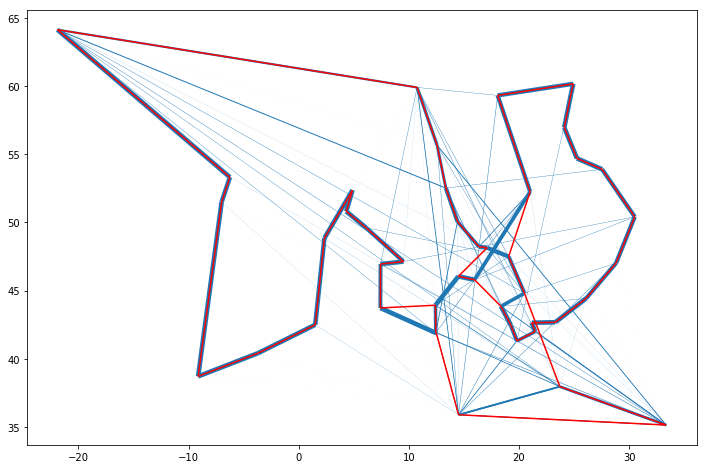

In [11]:
# vykreslime modre feromon, tloustka cary ukazuje mnozstvi feromonu na hrane
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

# vypiseme fitness reseni
print('Fitness: ', fitness(vertices, distance, solution))

# vypiseme primo poradi mest
solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

# vykreslime cervene reseni
solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])

solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])

solutions_lc = mc.LineCollection(solution_lines, colors='red')
ax.add_collection(solutions_lc)

## Úkol na cvičení

Poslední zmiňovaný algoritmus, který zde ale není naimplementovaný, je optimalizace pomocí včelí kolonie. Zkuste si ji tedy naimplementovat ve zbytku cvičení a vyřešit s ní třeba problém rastrigin funkce, který je výše vyřešený pomocí optimalizace hejna částic.

## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezeně vozidel jednoho stejného typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.


Svůj kód, popis řešení a výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline.